Check Python version

In [1]:
!python --version

Python 3.9.18


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [3]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [4]:
train_df = pd.read_csv(file_name)

In [5]:
train_df.shape

(144, 2)

In [6]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [7]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [9]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [10]:
train_df[target_col] = train_df[target_col].astype(float)

In [11]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

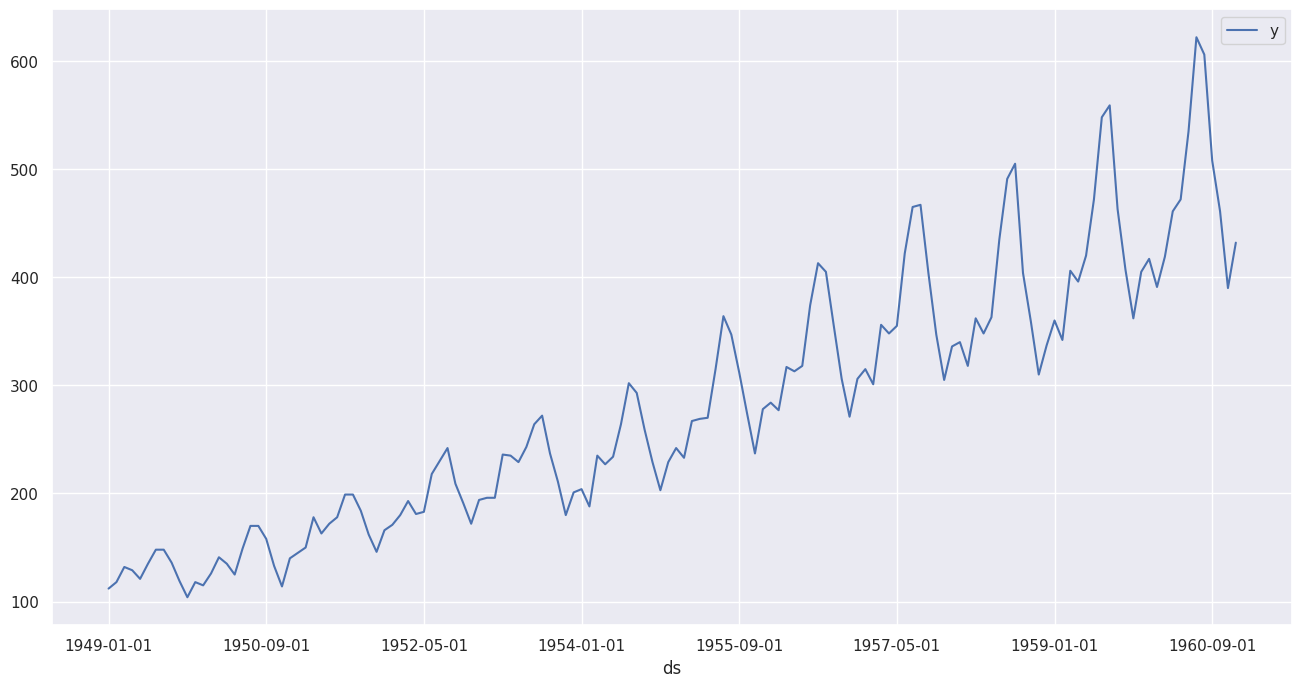

In [12]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [13]:
train_data = []

In [14]:
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [16]:
# Onboard NeuralProphet customized model request
np_model_request = {
    "params": {
      "changepoints_range": 0.2,
      "epochs": 2,
      "growth": "off"
    },
    "metrics": [],
    "type": "neuralprophet",
}

# Default model request
model_request = {
    'type': 'meta_lr',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_autoets'},
            {'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            {'type': 'neuralprophet', 'external_params': np_model_request}  # neuralprophet
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [17]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [18]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [19]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [20]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [21]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 22.1 ms, sys: 1.99 ms, total: 24.1 ms
Wall time: 9.4 s


In [22]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCAAAAwAAAAMAMH4BABQAAADOLQAAP4AAZWxzTZOMbyh0cpRzjG1vbnQUcnQpdF+MdGVlk4xkH22UeWGUcoFffWFyYmRilGSUlHlujElBkyiUc25hlERJH2h0eARwbGFwY3JlYXJzbXRyXIyMk4iM//9uAYxjdIxzH5RyAJSFlEv//24BiRanS9wer/GCE1XmKLlK7n/BUpQlH7b4ictc7ZEiZPU3yFmbLG7/kIMUVucpukuNHmDxgia3H/mKzF3uMMEDlCXJWpwtbwCR02SmN8hs/T/QEqM0dgdJH9prXu8xwgSVJmj5O8xdAZLUZac4yQuc3m8ApDV3CErbH2yuP4ESo0fYGqvtfg9R4iS1RjnKDJ3fcAFD1BaUZl+UH5SMGF9DYQluYm6BaCkuc25hZZRulEtSlIkDSv9dlJQCFVJOdGmUb2l9YXJlZJSUeCi4lACUaADghgAflF9zdGYKZ4mUlJSUcpRtlH1OlIWDbWiUbWFoYYFobSgHlEuHlEv//4DghrYfAGh0dpRhaIZtlHNtlF9yFHZvGF9vc2FycmZvX054c2kMFWFyjHRfdHV1coxkdIAKH3RyjGENcAtpcmMobk5ulAhzc28uc3J1bpQJdIw0Bk5fH2UTY25lX2xrX3RhdXKMYXKMdXaUdHJwcGg1lEuJTl9lAZR0wAofYXJ0bpRkYWFsb4EMWm1hAWUGR61AjIyUOoZjQGXH24wfIe2UaXRzB5RLUpQCrIQxLEBEYW25+7STJJQlaIcPQtofCOaTfykcndOCUbBnGvxV9Ib59Bpi4R9Db1R7r1OQ1o8f3NXAdqVJ9Tv7rchqOme315BQWwPkDrrE0mN76NfLtWMf3z19kvDXrxrY7Eolo989QckjxlyIB7/Dn9jcrH/aAVYf3zAeZE7jFlcmzCxckOCZWWWphSOUgkMpV/fd71iH1jAfHAdkJM1qLvibSd4FqIHafwajd7svUHnfgLwbt8cAI

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [23]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [24]:
model = train_json_out['model']

Forecast API JSON Payload

In [25]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [26]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [27]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 26.8 ms, sys: 0 ns, total: 26.8 ms
Wall time: 474 ms


In [28]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1960-12-31T00:00:00', 423.7711188669986],
  ['1961-01-30T00:00:00', 403.50138873855235],
  ['1961-03-01T00:00:00', 451.0348202077021],
  ['1961-03-31T00:00:00', 476.64092061225114],
  ['1961-04-30T00:00:00', 489.3551430725026],
  ['1961-05-30T00:00:00', 572.6308523613441],
  ['1961-06-29T00:00:00', 657.0183589833202],
  ['1961-07-29T00:00:00', 649.5086859372991],
  ['1961-08-28T00:00:00', 548.4133527583156],
  ['1961-09-27T00:00:00', 481.21795754868657],
  ['1961-10-27T00:00:00', 403.71818521156854],
  ['1961-11-26T00:00:00', 461.3338659701273],
  ['1961-12-26T00:00:00', 474.1543635935165],
  ['1962-01-25T00:00:00', 452.9878058044132],
  ['1962-02-24T00:00:00', 504.7475389941562],
  ['1962-03-26T00:00:00', 529.2921002785988],
  ['1962-04-25T00:00:00', 542.179589569899],
  ['1962-05-25T00:00:00', 629.9564757352264],
  ['1962-06-24T00:00:00', 718.2512332519887],
  ['1962-07-24T00:00:00', 710.4898191683824],
  ['1962-08-23T00:00:00', 603.9497352103913],
  ['1962-09-22T00:00:00

Combine forecast dates and output

In [29]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [30]:
forecast_df.shape

(24, 2)

In [31]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [32]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,423.771119
1,1961-01-30T00:00:00,403.501389
2,1961-03-01T00:00:00,451.034820
3,1961-03-31T00:00:00,476.640921
4,1961-04-30T00:00:00,489.355143


In [33]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,710.489819
20,1962-08-23T00:00:00,603.949735
21,1962-09-22T00:00:00,532.015312
22,1962-10-22T00:00:00,450.366649
23,1962-11-21T00:00:00,511.355268


Plot train and forecast side-by-side

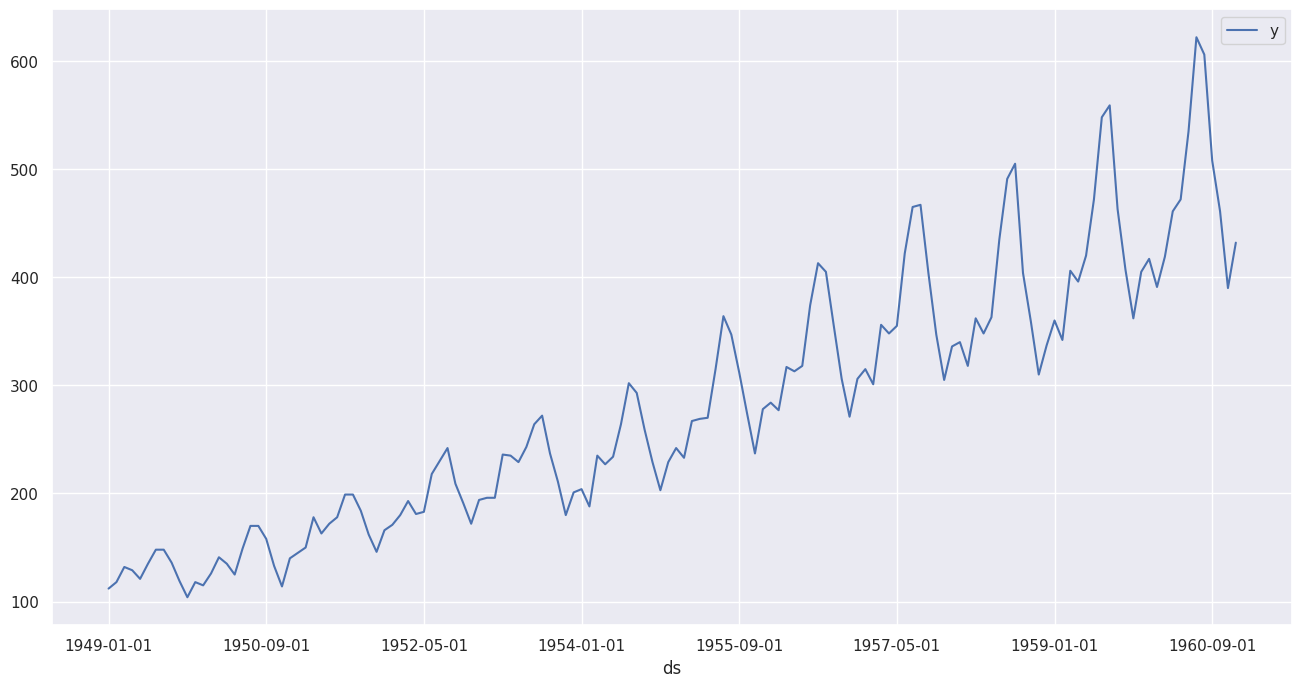

In [34]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

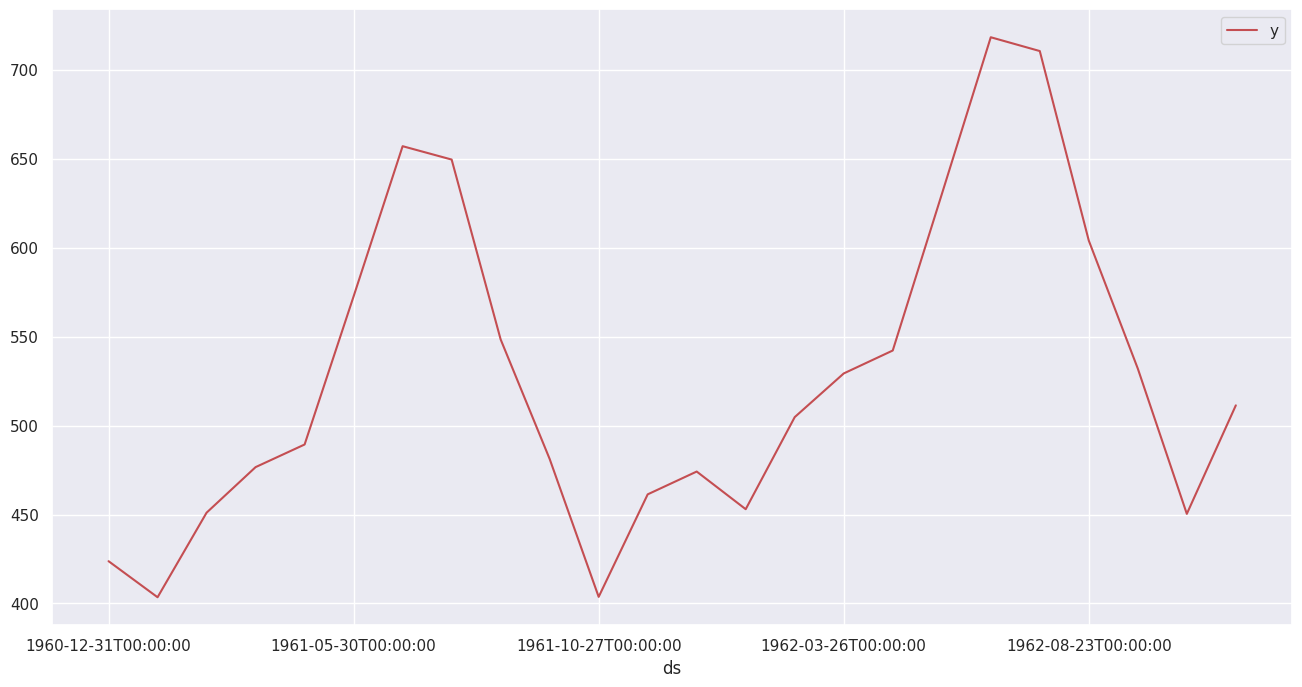

In [35]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [36]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [37]:
df.shape

(168, 3)

In [38]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [39]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,710.489819,r
164,1962-08-23T00:00:00,603.949735,r
165,1962-09-22T00:00:00,532.015312,r
166,1962-10-22T00:00:00,450.366649,r
167,1962-11-21T00:00:00,511.355268,r


Plot combined train and test sets with the vertical black line as the cut-off

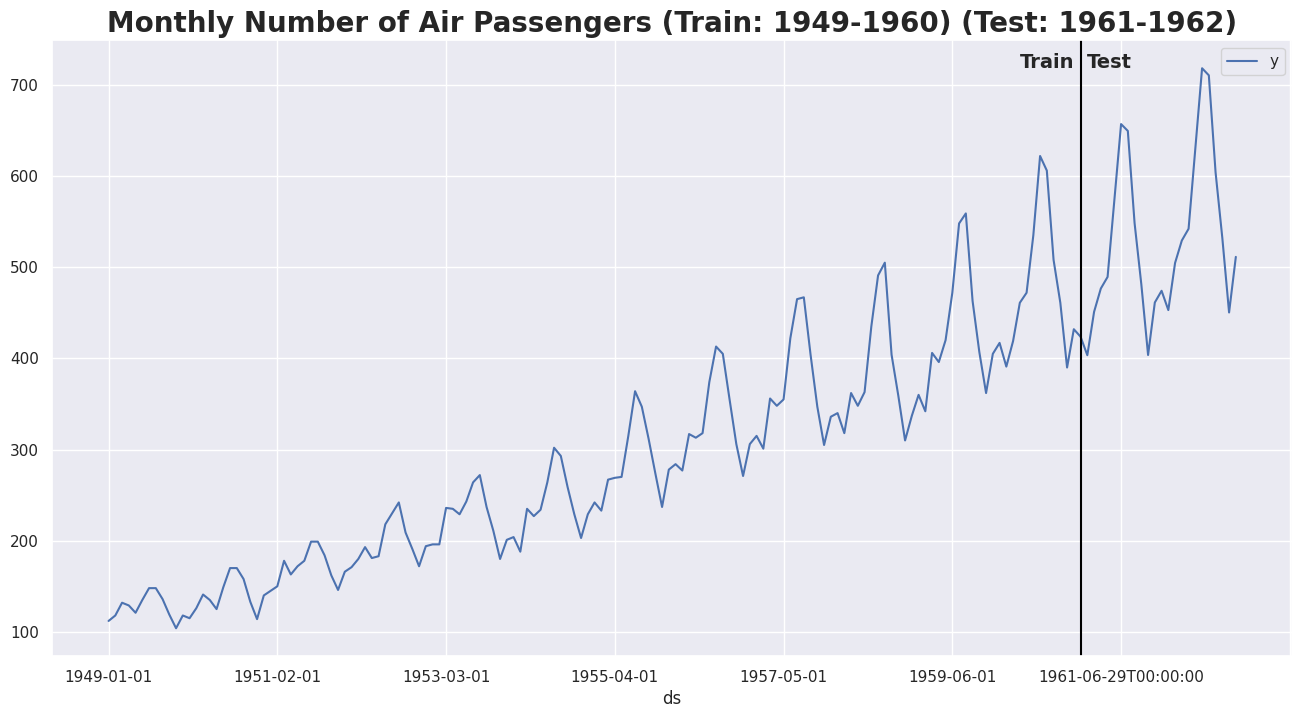

In [40]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();